In [47]:
import os, json
import torch, os


dir = '/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_53/interim_results'

In [43]:
for file in os.listdir(dir):
    if file.endswith('.json'):
        path = os.path.join(dir, file)
        try:
            with open(path, 'r') as f:
                data = json.load(f)
            if not isinstance(data, dict) or not data:  # Leer oder kein Dict
                print("⚠️ Leer/unklar:", file)
        except Exception as e:
            print("❌ Fehler in", file, "->", e)

        
for root, dirs, files in os.walk(dir):
    for file in files:
        if file.endswith('.ckpt'):
            path = os.path.join(root, file)
            try:
                ckpt = torch.load(path, map_location='cpu')
            except Exception as e:
                print("❌ Fehlerhafter Checkpoint:", path, "->", e)


In [48]:
from ray.tune import ExperimentAnalysis

exp_dir = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_53/"
analysis = ExperimentAnalysis(exp_dir)
for trial in analysis.trials:
    res = trial.last_result if hasattr(trial, "last_result") else {}
    if "silhouette" not in res:
        print(f"⚠️ Trial {trial.trial_id} fehlt silhouette!")


⚠️ Trial 10b0cc65 fehlt silhouette!
⚠️ Trial 51401cba fehlt silhouette!


Höchster Silhouette-Score: 0.18944455683231354


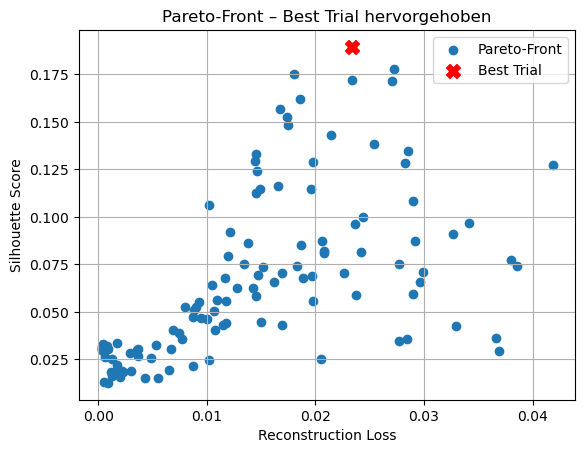

<Figure size 640x480 with 0 Axes>

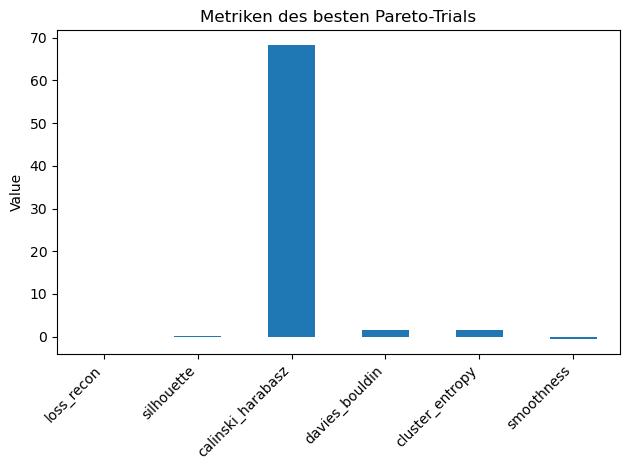

,Config Value
vae_lr,0.000034
clustering_lr,0.000014
recon_weight,0.099503
kld_weight,0.000015
gmm_end_value,0.006195
reg_end_value,0.458820
cat_end_value,0.049375
vae_lr_factor,0.777009
vae_lr_patience,10.000000
gmm_epochs,50.000000


In [52]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Pfade anpassen nach deinem Setup
metrics_dir = Path("/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_53/interim_results")

#ids_metrics = [tf.stem.split("trial_")[1] for tf in metrics_dir.glob("trial_*.json")]

# %% Zell 3: Metrics-Dateien einlesen und mit Config koppeln
pareto = []
for tf in metrics_dir.glob("trial_*.json"):
    trial = json.loads(tf.read_text(encoding="utf-8"))
    config = trial['config']
    trial_id = trial['trial_id']
    metrics = trial['metrics']

    pareto.append({
        "trial_id": trial_id,
        "config": config,
        "metrics": metrics
    })


# %% Zell 4: DataFrame bauen und filtern
df = pd.DataFrame([
    { **t["config"], **t["metrics"] }
    for t in pareto
])


df_clean = df[(df["silhouette"] > -999) & (df["loss_recon"] < 999)]

df_clean.head()


# %% Zell 5: Best Trial nach Silhouette finden
best = max(pareto, key=lambda t: t["metrics"]["silhouette"])
best_metrics = best["metrics"]
print("Höchster Silhouette-Score:", best_metrics["silhouette"])


# %% Zell 6: Pareto-Front Scatter-Plot
plt.figure()
plt.scatter(
    df_clean['loss_recon'], df_clean['silhouette'],
    label='Pareto-Front'
)
plt.scatter(
    best_metrics['loss_recon'], best_metrics['silhouette'],
    marker='X', s=100, c='red', label='Best Trial'
)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Silhouette Score")
plt.title("Pareto-Front – Best Trial hervorgehoben")
plt.legend()
plt.grid(True)
plt.show()


# %% Zell 7: Bar-Chart der Metriken des besten Trials
metrics_df = pd.DataFrame.from_dict(
    best_metrics, orient='index', columns=['Value']
)

plt.figure()
metrics_df.plot(kind='bar', legend=False)
plt.title("Metriken des besten Pareto-Trials")
plt.ylabel("Value")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# %% Zell 8: Konfig-DataFrame des besten Trials anzeigen
config_df = pd.DataFrame.from_dict(
    best["config"], orient='index', columns=['Config Value']
)
config_df


In [29]:
# %% Zell 1: Imports und Pfade
import json
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ordner mit deinen trial_*.json
metrics_dir = Path("/work/aa0238/a271125/logs_ray/"
                   "vae_gmm_multi_objective_scan/version_53/interim_results")

# Wurzel, unter der alle experiment_state-*.json liegen
logs_root = Path("/work/aa0238/a271125/logs_ray/"
                 "vae_gmm_multi_objective_scan/version_53")


In [30]:
# %% Zell 2: Debug – Verzeichnis prüfen
print("metrics_dir =", metrics_dir)
print("  exists?   ", metrics_dir.exists())
print("  is_dir?   ", metrics_dir.is_dir())
print("  Dateien:  ", sorted([p.name for p in metrics_dir.glob("trial_*.json")]))


metrics_dir = /work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_53/interim_results
  exists?    True
  is_dir?    True
  Dateien:   ['trial_001e725c.json', 'trial_02aa4288.json', 'trial_05818af4.json', 'trial_058cf6f3.json', 'trial_06e02ff5.json', 'trial_072693f1.json', 'trial_080aadac.json', 'trial_0829e617.json', 'trial_0a665263.json', 'trial_0ae6d3a2.json', 'trial_0b93faff.json', 'trial_11e7bb91.json', 'trial_14fb2573.json', 'trial_17577a49.json', 'trial_19698913.json', 'trial_1b840726.json', 'trial_2471c794.json', 'trial_2d0790e1.json', 'trial_2e1d097e.json', 'trial_2e1d383e.json', 'trial_2fddb39f.json', 'trial_32500c9c.json', 'trial_3358ade8.json', 'trial_35f3a581.json', 'trial_3663f16d.json', 'trial_3a6a084c.json', 'trial_3c82ef71.json', 'trial_3e7a97f8.json', 'trial_3fd0f224.json', 'trial_401ec607.json', 'trial_43e4291f.json', 'trial_454243f9.json', 'trial_4902e9e3.json', 'trial_4c365a3b.json', 'trial_4d6ef56f.json', 'trial_4d97ba64.json', 'trial_4f6e8349.json',

In [31]:
# %% Zell 3: Alle Metrik-JSONs laden
trials = []
for p in metrics_dir.glob("trial_*.json"):
    tid = p.stem.split("trial_")[1]
    data = json.loads(p.read_text(encoding="utf-8"))
    trials.append({"trial_id": tid, **data})

print(f"Anzahl geladener Trials: {len(trials)}")


Anzahl geladener Trials: 116


In [35]:
df_clean

# Baue Kosten-Matrix: jede Zeile ein Trial, jede Spalte ein Ziel
cost_matrix = np.vstack([
    df_clean["loss_recon"].to_numpy(),
    -df_clean["silhouette"].to_numpy(),
    df_clean["davies_bouldin"].to_numpy(),
    -df_clean["calinski_harabasz"].to_numpy(),
    -df_clean["smoothness"].to_numpy(),
]).T

# Pareto‐Front berechnen
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # Finde alle j, die von i dominiert werden
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

pareto_df = df_clean[is_pareto]
pareto_df

,vae_lr,clustering_lr,recon_weight,kld_weight,gmm_end_value,reg_end_value,cat_end_value,vae_lr_factor,vae_lr_patience,gmm_epochs,warmup_epochs,adapt_epochs,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,smoothness
2,0.002118,0.000335,0.093868,0.000107,0.006894,0.403404,0.011894,0.775108,30,50,20,20,0.023717,0.058902,24.554037,2.795664,1.601933,-0.601997
7,0.000025,0.000056,0.075456,0.002677,0.009893,0.262600,0.026417,0.771204,40,50,25,20,0.020468,0.024942,18.333910,4.443031,1.541807,-0.623837
8,0.001272,0.000002,0.007932,0.000065,0.007662,0.164250,0.001012,0.949948,20,150,30,20,0.002331,0.018201,12.220226,4.727336,1.579773,-0.609035
12,0.000548,0.000004,0.026319,0.000153,0.008948,0.223835,0.001910,0.797014,20,80,20,10,0.007723,0.035795,16.124905,3.394053,1.604534,-0.618987
18,0.000040,0.000014,0.009987,0.006804,0.009671,0.488295,0.019661,0.920693,40,100,25,15,0.002942,0.028570,13.625683,3.504902,1.609376,-0.628675
25,0.000976,0.000002,0.006826,0.000056,0.005494,0.341568,0.047895,0.758236,20,100,30,20,0.002006,0.015561,11.522488,4.423310,1.415408,-0.615144
27,0.000469,0.000003,0.022336,0.000635,0.006711,0.236237,0.001604,0.808912,20,80,20,10,0.006536,0.019537,12.645874,4.537699,1.591366,-0.619963
32,0.000044,0.000014,0.166061,0.006113,0.003693,0.207015,0.002307,0.792629,20,150,30,10,0.032950,0.042299,23.151882,3.345744,1.571320,-0.600917
35,0.000090,0.000110,0.031233,0.000349,0.003608,0.114497,0.022430,0.789970,30,50,20,20,0.008746,0.021599,15.322809,4.658594,1.589326,-0.612629
38,0.000940,0.000002,0.007461,0.000172,0.007472,0.336498,0.001782,0.718836,10,150,30,10,0.002193,0.018942,12.125012,4.249016,1.597068,-0.612373


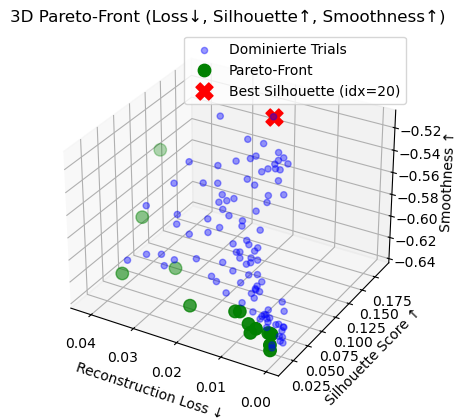

In [36]:
# %% Zell: Pareto‐Front und 3D‐Scatter für drei Ziele

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Annahme: df_clean enthält die Spalten 'loss_recon', 'silhouette', 'smoothness'
loss = df_clean["loss_recon"].to_numpy()
sil  = df_clean["silhouette"].to_numpy()
sm   = df_clean["smoothness"].to_numpy()

# 1) Kosten‐Matrix: wir wollen alles minimieren → für Max-Ziele nehmen wir das Negative
cost_matrix = np.vstack([
    loss,        # minimieren
    -sil,        # maximieren → minimiere -silhouette
    -sm,         # maximieren → minimiere -smoothness
]).T  # shape (n_trials, 3)

# 2) Pareto‐Front berechnen (Non‐Domination)
is_pareto = np.ones(len(cost_matrix), dtype=bool)
for i, c in enumerate(cost_matrix):
    if not is_pareto[i]:
        continue
    # dominated: alle j für die cost_matrix[j] <= c in allen Zielen
    # und < c in mindestens einem
    dominated = np.all(cost_matrix <= c, axis=1) & np.any(cost_matrix < c, axis=1)
    is_pareto[dominated] = False

# 3) 3D‐Scatter zeichnen
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# (a) dominierte Trials in hellgrau
ax.scatter(
    loss[~is_pareto],
    sil[~is_pareto],
    sm[~is_pareto],
    color="blue",
    alpha=0.4,
    label="Dominierte Trials"
)

# (b) Pareto‐Front in grün
ax.scatter(
    loss[is_pareto],
    sil[is_pareto],
    sm[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# (c) Best‐Silhouette als rotes Kreuz
best_idx = sil.argmax()
ax.scatter(
    loss[best_idx],
    sil[best_idx],
    sm[best_idx],
    color="red",
    marker="X",
    s=150,
    label=f"Best Silhouette (idx={best_idx})"
)

# Labels und Titel
ax.set_xlabel("Reconstruction Loss ↓")
ax.set_ylabel("Silhouette Score ↑")
ax.set_zlabel("Smoothness ↑")
ax.set_title("3D Pareto‐Front (Loss↓, Silhouette↑, Smoothness↑)")

# Optional: X‐Achse invertieren, damit links kleinste Loss ist
ax.invert_xaxis()

ax.legend()
plt.show()


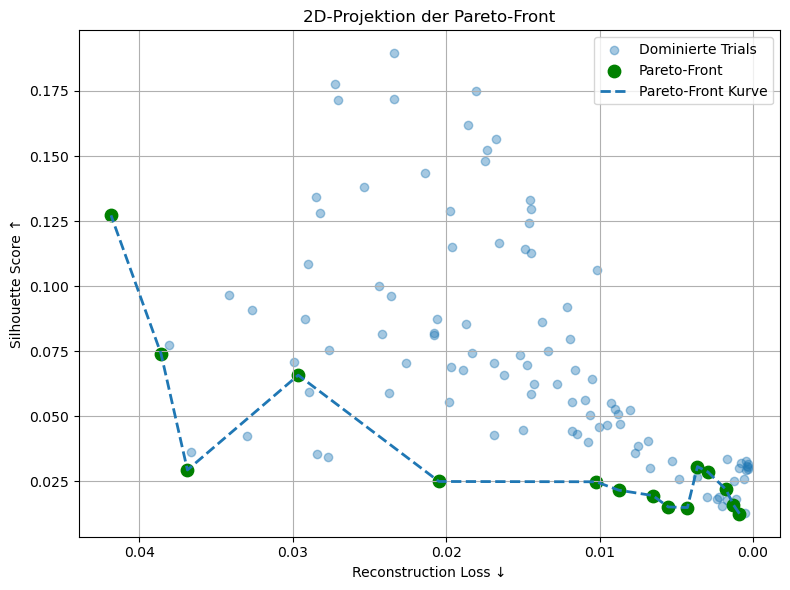

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Aus deinen vorhandenen Arrays:
# loss, sil, sm  (shape jeweils (n_trials,))
# is_pareto      (Boolean‐Array der Länge n_trials)

# 1) Wähle zwei Ziele für die 2D‐Visualisierung:
x = loss           # Reconstruction Loss (→ minimieren)
y = sil            # Silhouette Score (→ maximieren)

# 2) Scatterplot
plt.figure(figsize=(8, 6))

# a) Dominierte Trials
plt.scatter(
    x[~is_pareto],
    y[~is_pareto],
    alpha=0.4,
    label="Dominierte Trials"
)

# b) Pareto‐Front
plt.scatter(
    x[is_pareto],
    y[is_pareto],
    color="green",
    s=80,
    label="Pareto‐Front"
)

# 3) (Optional) Linie durch die Pareto‐Punkte
#    Sortiere erst nach x, damit die Linie nicht kreuzt
pareto_pts = np.vstack([x[is_pareto], y[is_pareto]]).T
pareto_sorted = pareto_pts[np.argsort(pareto_pts[:, 0])]
plt.plot(
    pareto_sorted[:, 0],
    pareto_sorted[:, 1],
    linestyle="--",
    linewidth=2,
    label="Pareto‐Front Kurve"
)

# 4) Achsen beschriften und invertieren (falls gewünscht)
plt.xlabel("Reconstruction Loss ↓")
plt.ylabel("Silhouette Score ↑")
plt.title("2D‐Projektion der Pareto‐Front")
plt.gca().invert_xaxis()   # damit links kleiner ist
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
